In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE, SelectFromModel
from collections import Counter
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed

Read and Encode test data

In [3]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
#df = df.sample(n=2000, replace=False, random_state=42)

model = SentenceTransformer("all-MiniLM-L6-v2")  
text_embeddings = model.encode(df["text"].astype(str).tolist(), convert_to_numpy=True)
df["text"] = text_embeddings.mean(axis=1)  
screen_name_embeddings = model.encode(df["screen_name"].astype(str).tolist(), convert_to_numpy=True)
df["screen_name"] = screen_name_embeddings.mean(axis=1)  

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [44]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train, y_train))

GBC using all features

In [ ]:
f1_scores = []
auc_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train_resampled, y_train_resampled)
    preds = gbc.predict(X_test)
    probs = gbc.predict_proba(X_test)[:, 1]  

    f1 = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
    auc = round(roc_auc_score(y_test, probs), 6)
    f1_scores.append(f1)
    auc_scores.append(auc)

mean_f1 = round(np.mean(f1_scores), 6)
mean_auc = round(np.mean(auc_scores), 6)

print(f"Mean F1 Score: {mean_f1}")
print(f"Mean AUC Score: {mean_auc}")

Mean F1 Score: 0.946116
Mean AUC Score: 0.620502


Variance Treshold Method

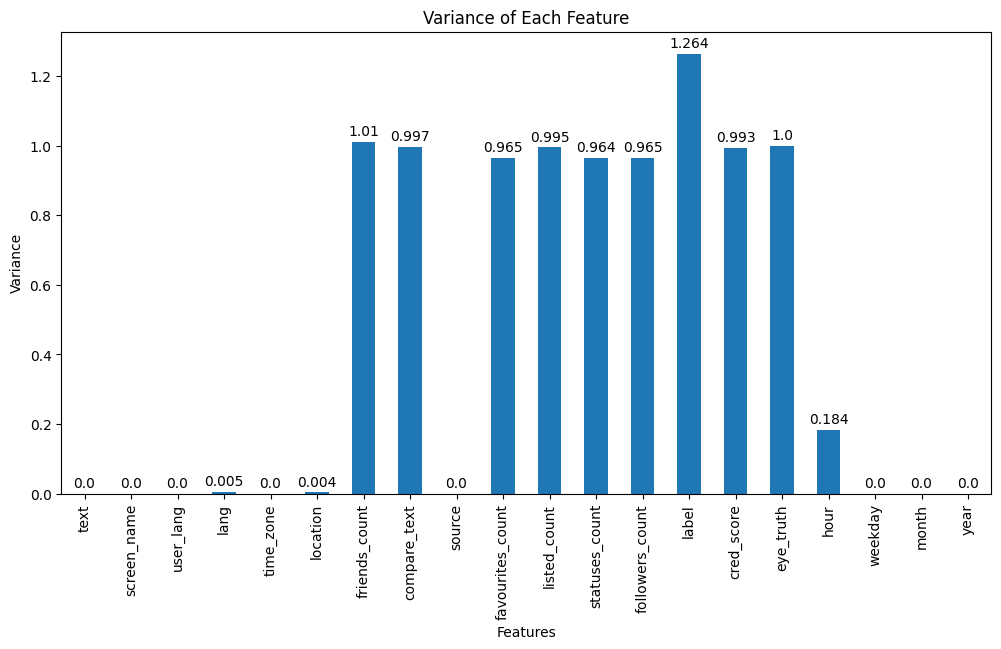

In [41]:
X_train_V, X_test_V, y_train_V, y_test_V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

Dropping Features with variance below 0.8

In [45]:
sel_X_train = X_train_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
sel_X_test = X_test_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(sel_X_train, y_train_V))

f1_scores = []
auc_scores = []

for train_index, test_index in kf.split(sel_X_train, y_train_V):
    X_train_fold, X_test_fold = sel_X_train.iloc[train_index], sel_X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_V.iloc[train_index], y_train_V.iloc[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train_resampled, y_train_resampled)
    preds = gbc.predict(X_test_fold)
    probs = gbc.predict_proba(X_test_fold)[:, 1]

    f1 = round(f1_score(y_test_fold, preds, average='weighted', zero_division=1), 6)
    auc = round(roc_auc_score(y_test_fold, probs), 6)
    f1_scores.append(f1)
    auc_scores.append(auc)

mean_f1 = round(sum(f1_scores) / len(f1_scores), 6)
mean_auc = round(sum(auc_scores) / len(auc_scores), 6)

print(f"Mean F1 Score: {mean_f1}")
print(f"Mean AUC Score: {mean_auc}")

Mean F1 Score: 0.803477
Mean AUC Score: 0.618556


SelectKbest feature selection (filter)

In [ ]:
X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train_resampled, y_train_resampled))

gbc = GradientBoostingClassifier(random_state=42)

def evaluate_kbest_kfold(k, X_train, y_train, folds):
    f1_scores = []
    auc_scores = []

    for train_index, test_index in folds:
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X_train_fold, y_train_fold)
        selected_X_train = selector.transform(X_train_fold)
        selected_X_test = selector.transform(X_test_fold)

        gbc.fit(selected_X_train, y_train_fold)
        preds = gbc.predict(selected_X_test)
        probs = gbc.predict_proba(selected_X_test)[:, 1]

        f1 = round(f1_score(y_test_fold, preds, average='weighted'), 3)
        auc = round(roc_auc_score(y_test_fold, probs), 3)
        f1_scores.append(f1)
        auc_scores.append(auc)

    return (
        round(sum(f1_scores) / len(f1_scores), 3),
        round(sum(auc_scores) / len(auc_scores), 3),
        k
    )

results = Parallel(n_jobs=-1)(
    delayed(evaluate_kbest_kfold)(k, X_train_resampled, y_train_resampled, folds) for k in range(1, 21)
)

f1_score_list, auc_score_list, feature_counts = zip(*results)

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.728, 0.706, 0.704, 0.703, 0.89, 0.89, 0.891, 0.891, 0.892, 0.901, 0.901, 0.9, 0.899, 0.901, 0.903, 0.903, 0.903, 0.903, 0.903, 0.902)
AUC Scores: (np.float64(0.8), np.float64(0.776), np.float64(0.777), np.float64(0.777), np.float64(0.942), np.float64(0.944), np.float64(0.946), np.float64(0.946), np.float64(0.947), np.float64(0.956), np.float64(0.956), np.float64(0.956), np.float64(0.957), np.float64(0.958), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


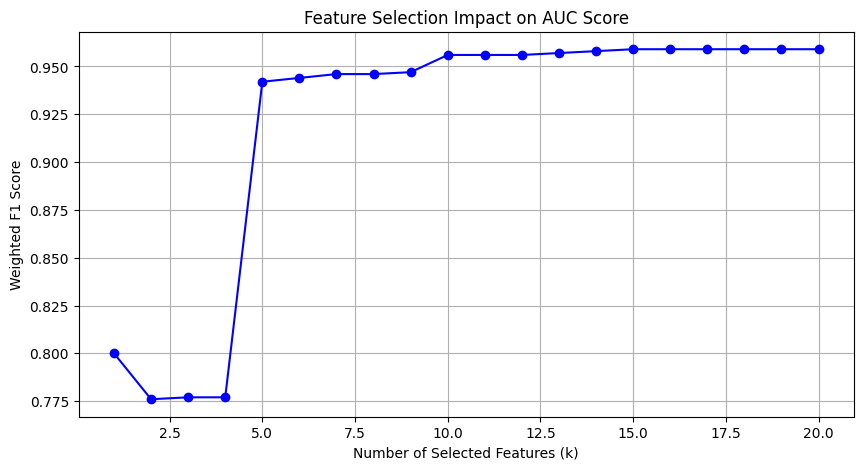

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, auc_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("Feature Selection Impact on AUC Score")
plt.grid(True)
plt.show()

Recursive Feature Elimination (Wrapper)

In [ ]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def evaluate_rfe(k, X_train_V2, y_train_V2):
    f1_scores = []
    auc_scores = []
    selected_features_list = []

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_V2, y_train_V2)
    X_resampled = pd.DataFrame(X_resampled, columns=X_train_V2.columns).reset_index(drop=True)
    y_resampled = pd.Series(y_resampled).reset_index(drop=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X_resampled, y_resampled):
        X_train_fold, X_test_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        gbc = GradientBoostingClassifier(random_state=42)
        RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
        RFE_selector.fit(X_train_fold, y_train_fold)

        sel_X_train_fold = RFE_selector.transform(X_train_fold)
        sel_X_test_fold = RFE_selector.transform(X_test_fold)
        selected_features = np.where(RFE_selector.support_)[0]
        selected_features_list.append(selected_features)

        gbc.fit(sel_X_train_fold, y_train_fold)
        preds = gbc.predict(sel_X_test_fold)
        probs = gbc.predict_proba(sel_X_test_fold)[:, 1]

        f1 = round(f1_score(y_test_fold, preds, average="weighted", zero_division=1), 3)
        auc = round(roc_auc_score(y_test_fold, probs), 3)
        f1_scores.append(f1)
        auc_scores.append(auc)

    return round(np.mean(f1_scores), 3), round(np.mean(auc_scores), 3), k, selected_features_list

results = Parallel(n_jobs=-1)(
    delayed(evaluate_rfe)(k, X_train_V2, y_train_V2) for k in range(1, 21)
)

f1_score_list, auc_score_list, feature_counts, selected_features_list = zip(*results)
selected_features_dict = {k: features for k, features in zip(range(1, 21), selected_features_list)}

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (np.float64(0.872), np.float64(0.904), np.float64(0.909), np.float64(0.918), np.float64(0.91), np.float64(0.906), np.float64(0.907), np.float64(0.905), np.float64(0.907), np.float64(0.907), np.float64(0.904), np.float64(0.906), np.float64(0.905), np.float64(0.906), np.float64(0.907), np.float64(0.909), np.float64(0.908), np.float64(0.908), np.float64(0.908), np.float64(0.908))
AUC Scores: (np.float64(0.895), np.float64(0.938), np.float64(0.941), np.float64(0.943), np.float64(0.958), np.float64(0.958), np.float64(0.959), np.float64(0.959), np.float64(0.96), np.float64(0.96), np.float64(0.96), np.float64(0.961), np.float64(0.96), np.float64(0.961), np.float64(0.96), np.float64(0.961), np.float64(0.961), np.float64(0.961), np.float64(0.961), np.float64(0.961))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


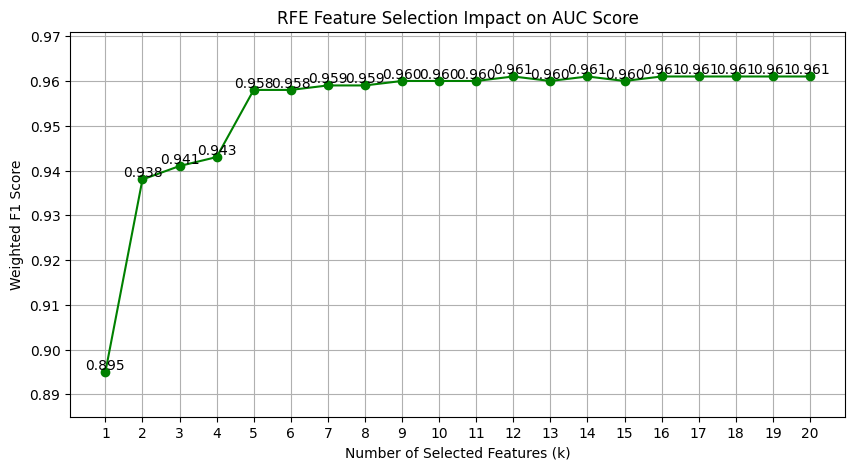

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), auc_score_list, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Weighted F1 Score")
plt.title("RFE Feature Selection Impact on AUC Score")
plt.xticks(range(1, 21))
plt.ylim(min(auc_score_list) - 0.01, max(auc_score_list) + 0.01)
plt.grid(True)

for i, score in enumerate(auc_score_list, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()
